In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook as tqdm_notebook

from data_functions import *
from metric_functions import *
from helper_functions import *
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hiperparametry

In [2]:
dataset = torch.load("final_data.tar")
train, val = trai_val_split(dataset, 0.8)

In [3]:
n_convs_values = [2, 5, 10, 20]
kernel_size_values = [3, 5, 7, 9]
stride_values = [1, 2, 3, 5]
padding_values = [1, 2, 3, 5]
n_channels_values = [16, 32, 64, 128]

In [4]:
res = pd.DataFrame(columns=["n_convs", "kernel_size", "stride", "padding", "n_channels", "train_loss", "train_acc", "val_acc", "overfit"])
nets = {}

### Liczba warstw konwolucyjnych

In [5]:
for n_convs in tqdm_notebook.tqdm(n_convs_values):
    n_channels = 10
    stride = 1
    padding = 1
    kernel_size = 3
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 25, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_195474/2431415162.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_res])


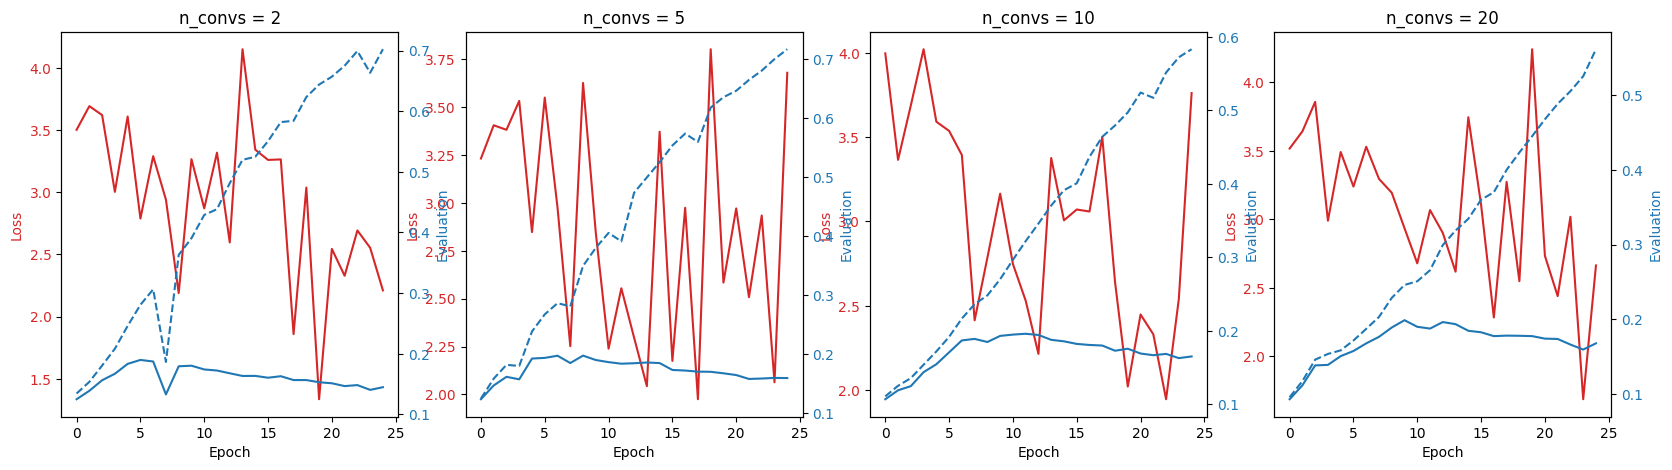

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, n_convs in enumerate(n_convs_values):
    iters = [i for i in range(25)]
    loss_hist = res[res["n_convs"] == n_convs]["train_loss"].values[0]
    train_acc = res[res["n_convs"] == n_convs]["train_acc"].values[0]
    val_acc = res[res["n_convs"] == n_convs]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"n_convs = {n_convs}")

- Wraz ze zwiększeniem liczby wartstw konwolucyjnych model robi się przetrenowany
- Trzeba polepszyć inne parametry żeby poprawić uogólnianie modelu

### Kernel size

In [6]:
for kernel_size in tqdm_notebook.tqdm(kernel_size_values):
    n_channels = 10
    stride = 1
    padding = 1
    n_convs = 3
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_384177/2691876052.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_res])


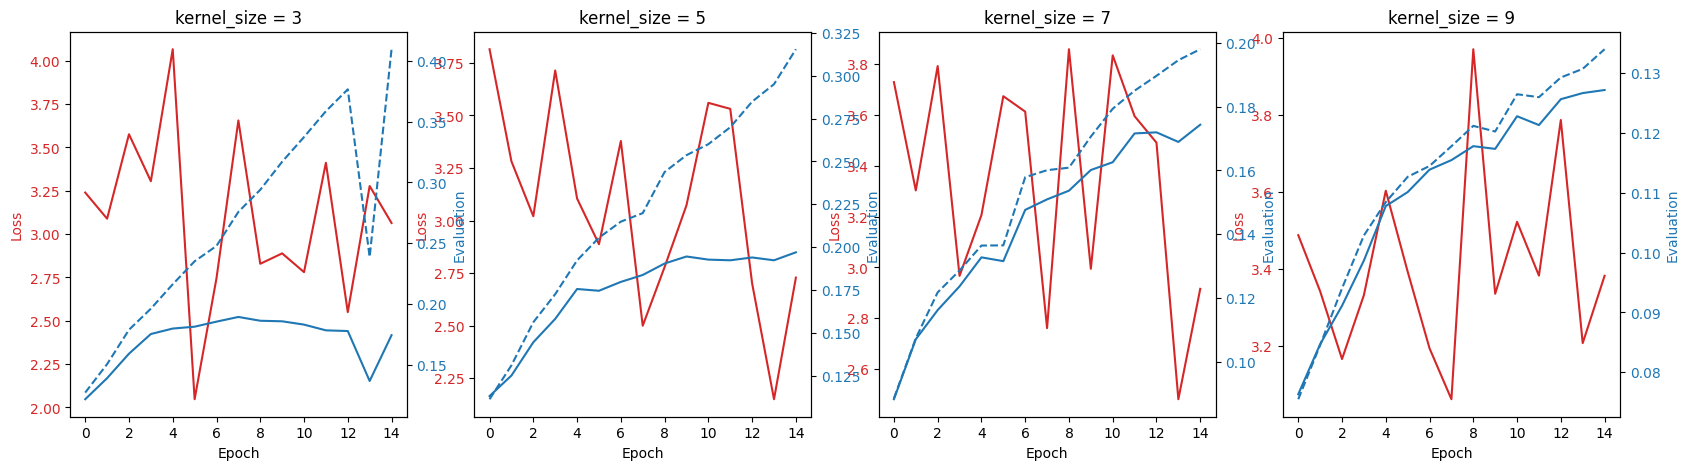

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, kernel_size in enumerate(kernel_size_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["kernel_size"] == kernel_size]["train_loss"].values[0]
    train_acc = res[res["kernel_size"] == kernel_size]["train_acc"].values[0]
    val_acc = res[res["kernel_size"] == kernel_size]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"kernel_size = {kernel_size}")

- Dla mniejszych wartości zbyt przetrenowany
- Dla większych bardzo słaba dokładność

### Stride

In [7]:
for stride in tqdm_notebook.tqdm(stride_values):
    n_channels = 10
    padding = 1
    n_convs = 2
    kernel_size = 3
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

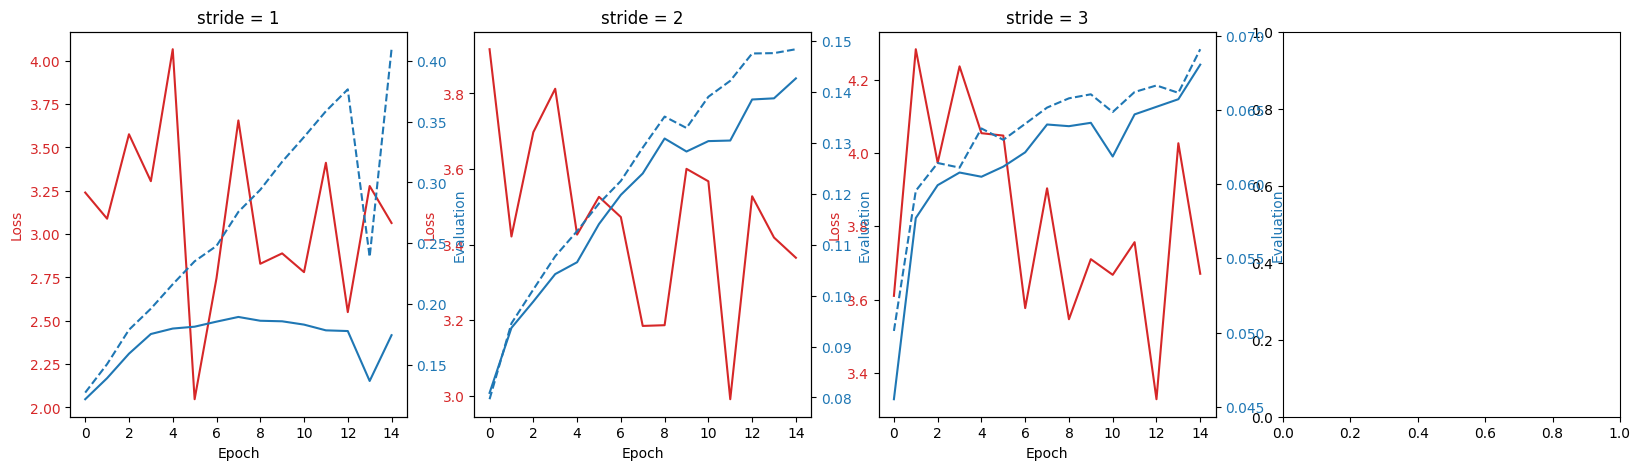

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, stride in enumerate(stride_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["stride"] == stride]["train_loss"].values[0]
    train_acc = res[res["stride"] == stride]["train_acc"].values[0]
    val_acc = res[res["stride"] == stride]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"stride = {stride}")

- Większy stride daje bardziej stabilne wyniki
- Gorsza ogólna dokładność ze zwiększeniem wartości

### Padding

In [8]:
for padding in tqdm_notebook.tqdm(padding_values):
    n_channels = 10
    n_convs = 2
    kernel_size = 3
    stride = 1
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

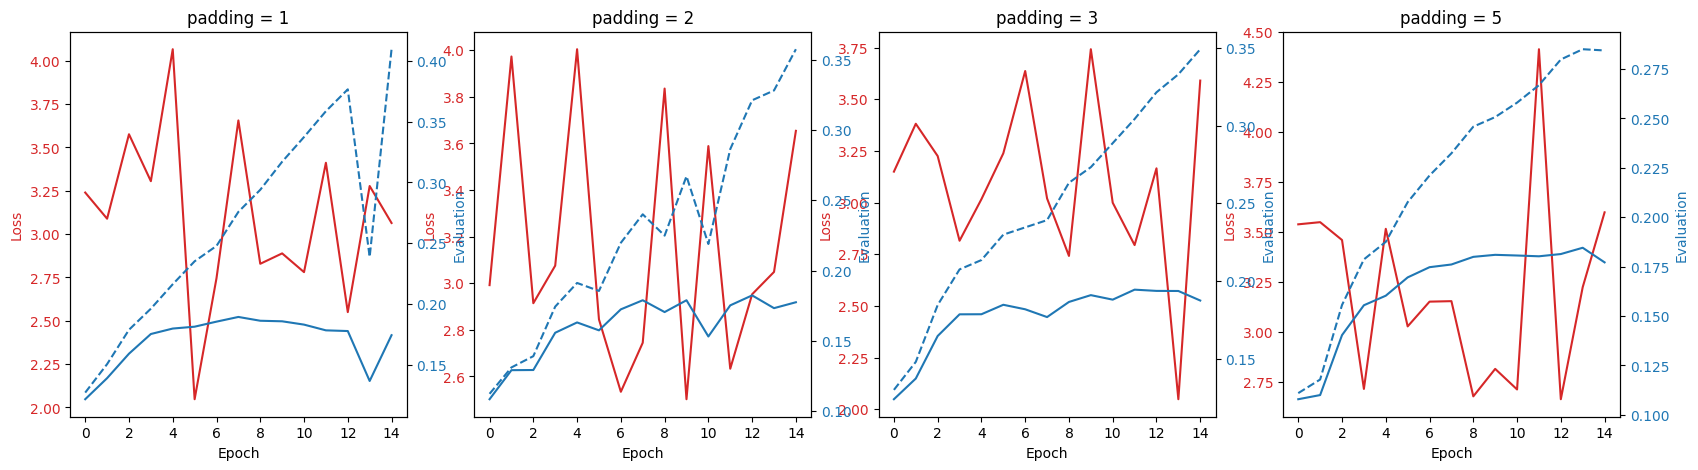

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, padding in enumerate(padding_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["padding"] == padding]["train_loss"].values[0]
    train_acc = res[res["padding"] == padding]["train_acc"].values[0]
    val_acc = res[res["padding"] == padding]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"padding = {padding}")

- Małe różnice w modelach
- Przy padding = 5 model robi się przetrenowany

### Liczba kanałów

In [9]:
for n_channels in tqdm_notebook.tqdm(n_channels_values):
    padding = 1
    n_convs = 2
    kernel_size = 3
    stride = 1
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding, n_channels=n_channels).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

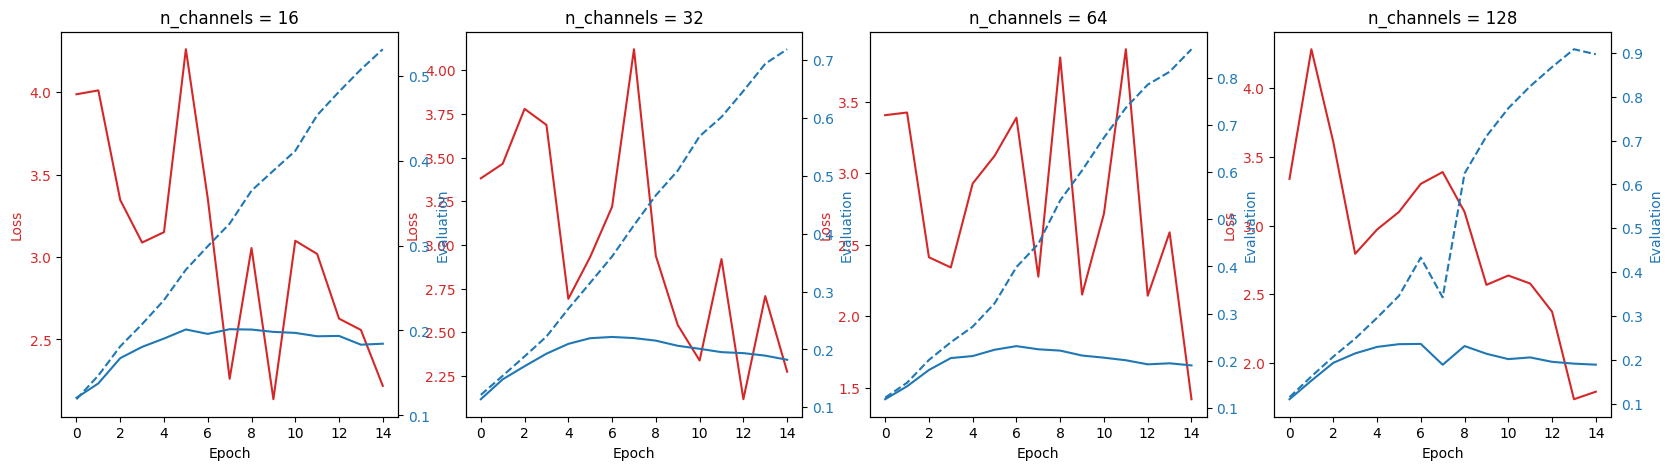

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, n_channels in enumerate(n_channels_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["n_channels"] == n_channels]["train_loss"].values[0]
    train_acc = res[res["n_channels"] == n_channels]["train_acc"].values[0]
    val_acc = res[res["n_channels"] == n_channels]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"n_channels = {n_channels}")

- Zwiększanie liczby kanałów przetrnowuje model
- Duża różnica pomiędzy zbiorem walidacyjnym i treningowym
- Większe wartości pozwalają na większą stabilność modelu